In [158]:
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import pandas as pd

import unicodedata, re, string
from nltk import word_tokenize

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import os
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

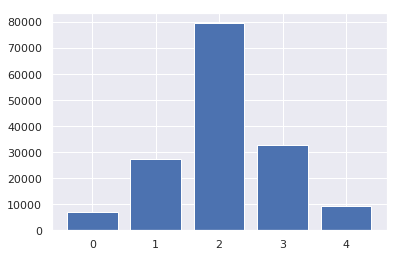

In [160]:
dist = df_train.groupby(["Sentiment"]).size()

#fig, ax = plt.subplots(figsize=(12,8))
plt.bar(dist.keys(), dist.values)
plt.show()

In [161]:
def clean_sentences(df):
    reviews = []
    for sent in tqdm(df['Phrase']):
        review_text = BeautifulSoup(sent).get_text()
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)

    return(reviews)
  
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)
df_train['Words'] = clean_sentences(df_train)
df_test['Words'] = clean_sentences(df_test)



  0%|          | 0/156060 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)

100%|██████████| 66292/66292 [00:33<00:00, 1991.15it/s]

In [162]:
#vocabulary
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}
print(word_set)
print(word_to_int)
# Check if they are still the same lenght
print(len(word_set))
print(len(word_to_int))

{'involved', 'logistically', 'supporting', 'animator', 'schmidt', 'asset', 'screening', 'yo', 'butthead', 'perception', 'grasping', 'ordeal', 'e', 'redundant', 'del', 'simpson', 'checklist', 'flavorful', 'pitted', 'passionately', 'unbearably', 'promoter', 'hermetic', 'lukewarm', 'moan', 'assembles', 'drowsy', 'heft', 'overkill', 'stubbornly', 'ish', 'infidelity', 'headed', 'j', 'stacked', 'trio', 'fair', 'sexploitation', 'loses', 'blanket', 'luscious', 'insistence', 'newfoundland', 'spectrum', 'squirming', 'conceptual', 'scholar', 'bristle', 'incinerates', 'stain', 'pact', 'leave', 'relic', 'reggio', 'hackneyed', 'satan', 'poet', 'raison', 'follows', 'martial', 'direct', 'diver', 'maneuver', 'scripting', 'distinction', 'ready', 'keeping', 'truncated', 'previous', 'pasolini', 'chelsea', 'awfully', 'retaliation', 'ape', 'feces', 'aplenty', 'phoned', 'weirdly', 'hottest', 'yosuke', 'lighting', 'outdated', 'immediately', 'uncouth', 'turf', 'bjorkness', 'ba', 'adrenalin', 'competently', 'ir

In [163]:
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [4688, 539, 8481, 1132, 211, 879, 8928, 5604, ...
1    [4688, 539, 8481, 1132, 211, 879, 8928, 5604, ...
2                                          [4688, 539]
3                                               [4688]
4                                                [539]
Name: Tokens, dtype: object

In [164]:
word_to_int['a']

4688

In [165]:
max_len = df_train['Tokens'].str.len().max()
print(max_len)

48


In [166]:
all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])
print(len(all_tokens))
print(encoded_labels)
# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features[:3])

156060
[1 2 2 ... 3 2 2]
[[ 4688   539  8481  1132   211   879  8928  5604  8458  2865 11902  1341
    879  2271  2865 12851 11902  1341   879  6135   158  8481   254  2184
   1999  8514   957  8481   254 11019   159   472  8481  4688  1995     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 4688   539  8481  1132   211   879  8928  5604  8458  2865 11902  1341
    879  2271     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 4688   539     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [167]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 48) 
Validation set: 	(15606, 48) 
Test set: 		(15606, 48)


In [168]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 54

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Check the size of the loaders (how many batches inside)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2312
289
289


In [0]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)##单向LSTM
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)##单向LSTM
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        #print("the size of x is", x.size())
        # embeddings and lstm_out
        embeds = self.embedding(x)
        #print("embeds's size is",embeds.size())
        #print("hidden's size is", len(hidden[1]))
        lstm_out, hidden = self.lstm(embeds, hidden)
        #print("out's size is", lstm_out.size())
        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        #print(hidden)
        return hidden


In [207]:
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(13746, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [0]:
lr=0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [0]:
epochs = 3 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
#if(train_on_gpu):
#    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        
        #print(inputs.size())
        counter += 1

    
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                #if(train_on_gpu):
                #    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())
.L
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 1.212199... Val Loss: 1.306470
Epoch: 1/3... Step: 200... Loss: 1.275084... Val Loss: 1.306045
Epoch: 1/3... Step: 300... Loss: 1.277319... Val Loss: 1.302296
Epoch: 1/3... Step: 400... Loss: 1.116318... Val Loss: 1.310381
Epoch: 1/3... Step: 500... Loss: 1.248131... Val Loss: 1.305886
Epoch: 1/3... Step: 600... Loss: 1.342008... Val Loss: 1.301867
Epoch: 1/3... Step: 700... Loss: 1.283794... Val Loss: 1.303953
Epoch: 1/3... Step: 800... Loss: 1.239092... Val Loss: 1.307689
Epoch: 1/3... Step: 900... Loss: 1.301800... Val Loss: 1.300407
Epoch: 1/3... Step: 1000... Loss: 1.236304... Val Loss: 1.304329
Epoch: 1/3... Step: 1100... Loss: 1.199864... Val Loss: 1.302939
Epoch: 1/3... Step: 1200... Loss: 1.419592... Val Loss: 1.303062
Epoch: 1/3... Step: 1300... Loss: 1.186372... Val Loss: 1.300815
Epoch: 1/3... Step: 1400... Loss: 1.276218... Val Loss: 1.267355
Epoch: 1/3... Step: 1500... Loss: 1.002968... Val Loss: 1.245688
Epoch: 1/3... Step: 1600... Loss: 

In [0]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))